In [5]:
import numpy as np
from numpy import abs, sqrt, log10, sin, cos, exp, cosh, tanh, log, conj, cosh, sinh
np.set_printoptions(precision=16)
from math import pi, factorial
from numpy.random import rand
from numpy.linalg import norm
import scipy
import scipy.sparse as sp
from scipy.sparse import linalg, csc_matrix
import time
from scipy.optimize import minimize
from scipy.special import eval_hermite

%matplotlib inline
import matplotlib.pyplot as plt
%config InlineBackend.figure_format ="retina"
import matplotlib as mpl
#mpl.rcParams["figure.dpi"] = 
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

import pickle

from qonn_cobyla import *

from qutip import *

import matplotlib as mpl

from matplotlib import cm

from numpy import array
from numpy import count_nonzero

from scipy.signal import find_peaks, savgol_filter

In [6]:
def get_wigner(psi):
    '''
    This function gets the Wigner quasiprobability distribution of the pure state psi (in QuTiP).
    '''

    rho = psi[:, np.newaxis] @ psi[np.newaxis, :].conj()

    # We trace out the second mode
    basis_1 = csc_matrix(np.eye(N_p+1, dtype=np.complex128))
    basis_2 = csc_matrix(np.eye(N_p+1, dtype=np.complex128))
    rho_1 = 0 # Initialize reduced density matrix of mode 1
    for j in range(N_p+1):
        rho_1 += sp.kron(basis_2[:, j].H, basis_1) @ rho @ sp.kron(basis_2[:, j], basis_1)

    rho_1_qutip = Qobj(rho_1)
    xvec = np.linspace(-sqrt(N_p), sqrt(N_p), 200)
    W_1 = wigner(rho_1_qutip, xvec, xvec)

    return W_1

In [7]:
def QFI_explicit(psi):
    '''
    This function calculates the QFI of the pure state psi.
    '''

    psi_phi = np.copy(psi)
    # Encoding (MZ interferometer)
    psi_phi = sp.linalg.expm_multiply(-1j * (0*sp.eye(setup.d_c, dtype=np.complex128) + setup.H_BS_sym()), psi_phi)
    psi_phi = sp.linalg.expm_multiply(-1j * (phi[1] * setup.H_phi() ), psi_phi)
    psi_phi = sp.linalg.expm_multiply(-1j * (0*sp.eye(setup.d_c, dtype=np.complex128) + setup.H_BS_sym()), psi_phi)
    
    psi_delta = np.copy(psi)
    # Encoding (MZ interferometer)
    psi_delta = sp.linalg.expm_multiply(-1j * (0*sp.eye(setup.d_c, dtype=np.complex128) + setup.H_BS_sym()), psi_delta)
    psi_delta = sp.linalg.expm_multiply(-1j * (phi_delta[1] * setup.H_phi() ), psi_delta)
    psi_delta = sp.linalg.expm_multiply(-1j * (0*sp.eye(setup.d_c, dtype=np.complex128) + setup.H_BS_sym()), psi_delta)

    # Evaluate QFI
    F = np.abs(psi_phi[np.newaxis, :].conj() @ psi_delta[:, np.newaxis])
    cost = (8*(1-F)/delta**2)[0][0]

    return cost

Fit exponent = -0.11863295015689027
Fit exponent = -0.3061326857264204


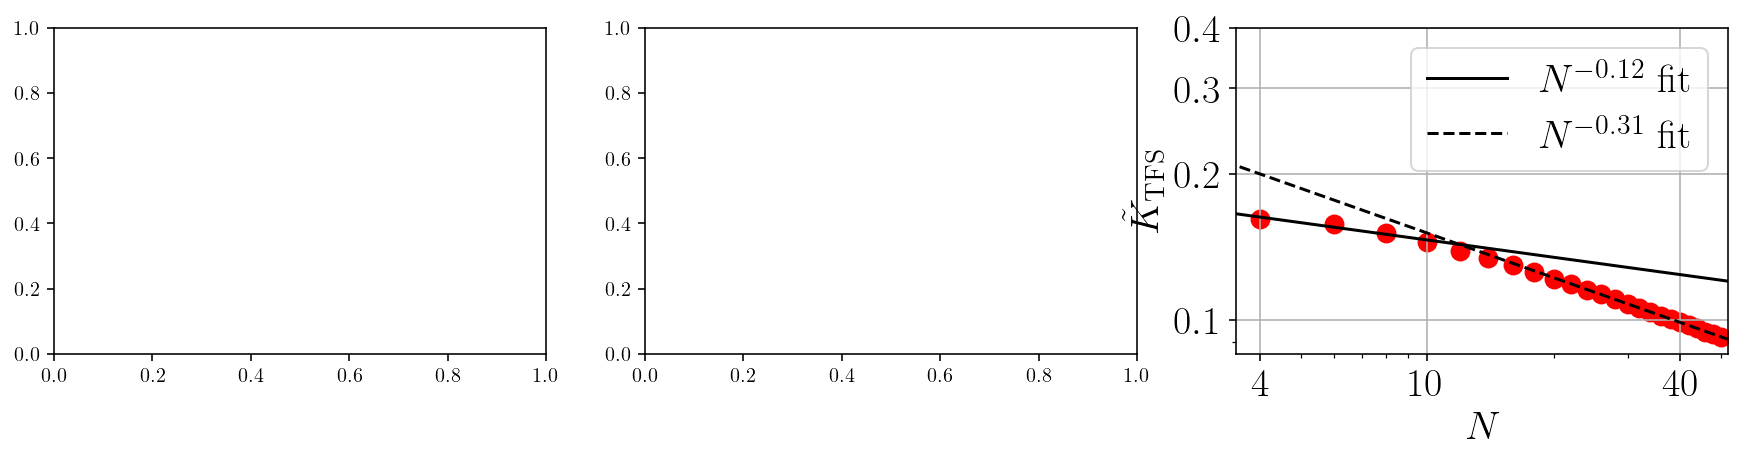

In [9]:
k = 2

ordinals = ['st', 'nd', 'rd', 'th']
colors = ['red', 'blue', 'green', 'black']
markers = ['o', 's', '^', 'd']

# We plot the ultimate estimation error given by the QFI
plt.rcParams["figure.figsize"] = [15, 3]
fig, ax = plt.subplots(1, 3)
marker_size = 80
fs = 20



# Time below TFS ###############################################################################################



'''
t_vec = np.linspace(0, 0.4, 2000)
N_list = np.arange(4, 104, 4)/2
with open('QFI_F_k={:}.p'.format(int(k)), 'rb') as file: 
    input = pickle.load(file) 
QFI_matrix = input[0]
F_matrix = input[1]
Dphi = 1/QFI_matrix

indices_matrix = []
for i_N, N in enumerate(N_list[1:]):
    indices = [i for i, x in enumerate(Dphi[i_N+1]) if x < 2/(N*(N+2))]
    indices_matrix.append(indices[0])
'''



with open('QFI_uptoN_k={:}.p'.format(int(k)), 'rb') as file: 
    input = pickle.load(file) 
N_list = input[0]
t_vec = input[1]
QFI_matrix = input[2]
Dphi = 1/QFI_matrix

indices_matrix = []
for i_N, N_p in enumerate(N_list[1:]):
    N = N_p/2
    indices = [i for i, x in enumerate(Dphi[i_N+1]) if x < 2/(N*(N+2))]
    indices_matrix.append(indices[0])

N_list = N_list / 2

ax[-1].scatter(N_list[1:], t_vec[indices_matrix], marker_size, color='red')

x = log10(N_list[1:5])
y = log10(t_vec[indices_matrix][:4])
p = np.polyfit(x, y, 1)
x_fit = np.linspace(0.09, 2, 100)
y_fit = p[0]*x_fit + p[1]
ax[-1].plot(10**x_fit, 10**y_fit, '-k', label=r'$N^{{{:.2f}}}$ fit'.format(p[0]))
print('Fit exponent = {:}'.format(p[0]))

x = log10(N_list[11:])
y = log10(t_vec[indices_matrix][10:])
p = np.polyfit(x, y, 1)
x_fit = np.linspace(0.09, 2, 100)
y_fit = p[0]*x_fit + p[1]
ax[-1].plot(10**x_fit, 10**y_fit, '--k', label=r'$N^{{{:.2f}}}$ fit'.format(p[0]))
print('Fit exponent = {:}'.format(p[0]))


ax[-1].set_xlabel(r'$N$',fontsize=fs)
ax[-1].tick_params(axis='both', labelsize=fs)


ax[-1].grid()
ax[-1].set_xlabel(r'$N$',fontsize=fs)
ax[-1].tick_params(axis='both', labelsize=fs)
ax[-1].set_xlim(3.5, 52)
ax[-1].set_xscale('log')
ax[-1].set_yscale('log')
ax[-1].set_xticks([4, 10, 40])
ax[-1].set_xticklabels([r'$4$', r'$10$', r'$40$']) 

ax[-1].set_ylabel(r'$\tilde{K}_{\rm TFS}$', fontsize=fs)
#ax.set_yticks(np.arange(0.1, 0.5, 0.1))
#ax.set_yticklabels([r'$0.1$', r'$0.2$', r'$0.3$', r'$0.4$'])
#ax.set_ylim(8.5e-2, 4e-1)
ax[-1].set_ylim(8.5e-2, 4e-1)

ax[-1].legend(loc='upper right', fontsize=fs)

ax[-1].set_yticks([1e-1, 2e-1, 3e-1, 4e-1])
ax[-1].set_yticklabels([r'$0.1$', r'$0.2$', r'$0.3$', r'$0.4$'])


# Analytic results for the fidelity decay time
#t_decay = 1 / ( sqrt(2) * N_list**(3/2) )
#ax.plot(N_list, t_decay, '-r')


plt.savefig('Figure 4 v3.svg', bbox_inches='tight', dpi=600)